In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!
Out[5]: True

In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import plotly.express as px


In [0]:
data = pd.read_csv("/dbfs/FileStore/amazon_reviews_us_Mobile_Electronics_v1_00.csv", low_memory=False)
data.head()

Out[7]:

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefgÂ® FBI Covert Acoustic Tube Earpiece...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data = data[['review_body','star_rating']]
data.dropna(inplace=True)
data['star_rating'] = data['star_rating'].astype(int)

In [0]:
### Over sampling to balance Dataset

In [0]:
data['star_rating'].value_counts()

Out[10]: 5 52198
4 18063
1 17572
3 9720
2 7298
Name: star_rating, dtype: int64

In [0]:
data['len'] = data['review_body'].apply(lambda s : len(s))

In [0]:
data  = data[data.len >1]

Out[13]:

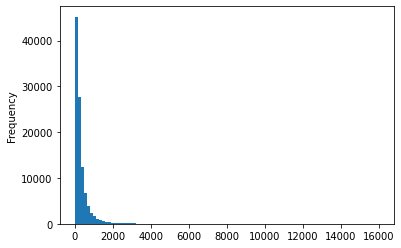

<AxesSubplot:ylabel='Frequency'>

In [0]:
data['len'].plot.hist(bins=100)

In [0]:
data.len.quantile(0.9)

Out[14]: 728.0

In [0]:
data.star_rating.value_counts()

Out[15]: 5 52186
4 18056
1 17572
3 9719
2 7298
Name: star_rating, dtype: int64

### Cleaning

In [0]:
import copy
df = copy.deepcopy(data)

In [0]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x
def remove_punctuation(x):
  new_string = re.sub(r'[^\w\s]', '', x)
  return new_string

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

Out[18]: 'this is a text with contraction'

In [0]:
# lower the text
df["review_body"] = df["review_body"].apply(lambda x: x.lower())

# Clean the text
df["review_body"] = df["review_body"].apply(lambda x: clean_text(x))

# Clean numbers
df["review_body"] = df["review_body"].apply(lambda x: clean_numbers(x))

# Clean Contractions
df["review_body"] = df["review_body"].apply(lambda x: replace_contractions(x))

df["review_body"] = df["review_body"].apply(lambda x: remove_punctuation(x))

In [0]:
count_df = df[['review_body','star_rating']].groupby('review_body').aggregate({'star_rating':'count'}).reset_index().sort_values('star_rating',ascending=False)
count_df.head(120)

Out[20]:

,review_body,star_rating
14751,good,277
98629,works great,218
16607,great,203
11513,excellent,162
18169,great product,132
...,...,...
93589,very nice product,5
100615,yes,5
19513,great value,5
52171,item delivered on time was as described,5


In [0]:
px.bar(count_df[count_df['star_rating']>4],x='review_body',y='star_rating')

Out[21]:

In [0]:
df['len'].max(),df['len'].min(), df['len'].mean()

Out[22]: (16009, 2, 342.49720025564955)

In [0]:
df['len'].describe()

Out[23]: count 104831.000000
mean 342.497200
std 526.515147
min 2.000000
25% 115.000000
50% 190.000000
75% 381.500000
max 16009.000000
Name: len, dtype: float64

Out[24]:

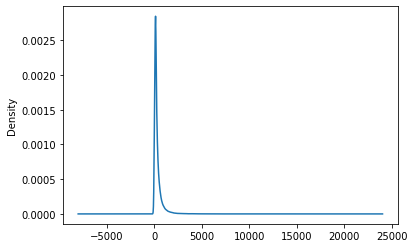

<AxesSubplot:ylabel='Density'>

In [0]:
df['len'].plot.kde()

In [0]:
df.drop("len",inplace = True, axis=1)

In [0]:
df.star_rating.value_counts()

Out[26]: 5 52186
4 18056
1 17572
3 9719
2 7298
Name: star_rating, dtype: int64

In [0]:
df1= pd.get_dummies(df['star_rating'])
df2 = pd.concat([df,df1],axis=1)
df2.drop("star_rating", inplace = True, axis=1)
df2.head()

Out[61]:

,review_body,1,2,3,4,5
0,as advertised everything works perfectly i am ...,0,0,0,0,1
1,it is great,0,0,0,0,1
2,these work great and fit my life proof case fo...,0,0,0,0,1
3,work very well but could not get used to not h...,0,0,0,1,0
4,be careful with these products i have bought s...,0,1,0,0,0


In [0]:
df2.columns

Out[62]: Index(['review_body', 1, 2, 3, 4, 5], dtype='object')

Out[63]:

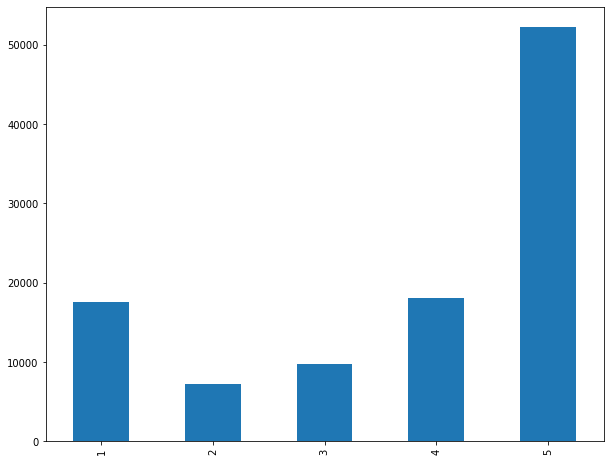

<AxesSubplot:>

In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df2[[ 1, 2, 3, 4, 5]].sum(axis=0).plot.bar()

In [0]:
X = []
sentences = list(df["review_body"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df2[[ 1, 2, 3, 4, 5]].values

In [0]:
type(y[0])

Out[55]: numpy.int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
y_train

Out[67]: array([[0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 ...,
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0]], dtype=uint8)

In [0]:
%sh
wget https://nlp.stanford.edu/data/glove.6B.zip -P /dbfs/tmp/glove


--2022-04-10 15:13:10-- https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-10 15:13:11-- http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/dbfs/tmp/glove/glove.6B.zip’

 0K .......... .......... .......... .......... .......... 0% 214K 65m26s
 50K .......... .......... .......... .......... .......... 0% 345K 53m2s
 100K .......... .......... .......... .......... .......... 0% 264K 53m5s
 150K .......... .......... .......... .......... .......... 0% 207K 56m44s
 200K .......... .......... .......... .......... .......... 0% 553K 50m27s
 250K .......... .......... .......... .......... .......... 0% 495K 46m46s
 300K .......... .......... .......... .......... .......... 0% 24.7M 40m10s
 350K .......... .......... .......... .......... .......... 0% 525K 38m29s
 400K .......... .......... .......... .......... .......... 0% 1.06M 35m38s
 450K .......... .......... .......... .......... .......... 0% 23.9M 32m8s
 500K .......... .......... .......... .......... .......... 0% 35.4M 29m15s
 550K .......... .......... .......... .......... .......... 0% 1.21M 27m45s
 600K .......... .......... .......... .......... .......... 0% 921K 26m47s
 650K .......... .......... .......... .......... .......... 0% 1.02M 25m49s
 700K .......... .......... .......... .......... .......... 0% 22.9M 24m8s
 750K .......... .......... .......... .......... .......... 0% 30.1M 22m40s
 800K .......... .......... .......... .......... .......... 0% 26.0M 21m21s
 850K .......... .......... .......... .......... .......... 0% 29.1M 20m12s
 900K .......... .......... .......... .......... .......... 0% 29.8M 19m9s
 950K .......... .......... .......... .......... .......... 0% 29.1M 18m13s
 1000K .......... .......... .......... .......... .......... 0% 27.8M 17m22s
 1050K .......... .......... .......... .......... .......... 0% 608K 17m38s
 1100K .......... .......... .......... .......... .......... 0% 24.6M 16m53s
 1150K .......... .......... .......... .......... .......... 0% 1.08M 16m43s
 1200K .......... .......... .......... .......... .......... 0% 18.2M 16m4s
 1250K .......... .......... .......... .......... .......... 0% 23.5M 15m28s
 1300K .......... .......... .......... .......... .......... 0% 27.3M 14m55s
 1350K .......... .......... .......... .......... .......... 0% 31.1M 14m24s
 1400K .......... .......... .......... .......... .......... 0% 25.0M 13m55s
 1450K .......... .......... .......... .......... .......... 0% 29.8M 13m28s
 1500K .......... .......... .......... .......... .......... 0% 32.2M 13m3s
 1550K .......... .......... .......... .......... .......... 0% 32.7M 12m39s
 1600K .......... .......... .......... .......... .......... 0% 29.6M 12m17s
 1650K .......... .......... .......... .......... .......... 0% 32.8M 11m56s
 1700K .......... .......... .......... .......... .......... 0% 32.2M 11m36s
 1750K .......... .......... .......... .......... .......... 0% 31.6M 11m18s
 1800K .......... .......... .......... .......... .......... 0% 27.0M 11m0s
 1850K .......... .......... .......... .......... .......... 0% 30.8M 10m43s
 1900K .......... .......... .......... .......... .......... 0% 29.9M 10m28s
 1950K .......... .......... .......... .......... .......... 0% 2.70M 10m19s
 2000K .......... .......... .......... .......... .......... 0% 30.1M 10m5s
 2050K .......... .......... .......... .......... .......... 0% 961K 10m11s
 2100K .......... .....

In [0]:
dbutils.fs.ls("/tmp/glove")

Out[39]: [FileInfo(path='dbfs:/tmp/glove/.bert_classification_tensorflow.crc', name='.bert_classification_tensorflow.crc', size=5292568),
 FileInfo(path='dbfs:/tmp/glove/4', name='4', size=1237),
 FileInfo(path='dbfs:/tmp/glove/bert_classification_tensorflow', name='bert_classification_tensorflow', size=677447496),
 FileInfo(path='dbfs:/tmp/glove/bert_sequence_classifier_multilingual_sentiment_xx_3.3.2_3.0_1635934569723.zip', name='bert_sequence_classifier_multilingual_sentiment_xx_3.3.2_3.0_1635934569723.zip', size=628096800),
 FileInfo(path='dbfs:/tmp/glove/download', name='download', size=6587),
 FileInfo(path='dbfs:/tmp/glove/fields/', name='fields/', size=0),
 FileInfo(path='dbfs:/tmp/glove/glove.6B.zip', name='glove.6B.zip', size=862182613),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.txt', name='glove.840B.300d.txt', size=5646236541),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip', name='glove.840B.300d.zip', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.1', name='glove.840B.300d.zip.1', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.2', name='glove.840B.300d.zip.2', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.3', name='glove.840B.300d.zip.3', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/metadata/', name='metadata/', size=0),
 FileInfo(path='dbfs:/tmp/glove/models/', name='models/', size=0)]

In [0]:
import zipfile
# EXTRACT if Necessary
# Unzip and extract in file. Maybe, could be better to unzip in memory with StringIO.
with zipfile.ZipFile('/dbfs/tmp/glove/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/dbfs/tmp/glove/')

In [0]:
dbutils.fs.ls("/tmp/glove")

Out[41]: [FileInfo(path='dbfs:/tmp/glove/.bert_classification_tensorflow.crc', name='.bert_classification_tensorflow.crc', size=5292568),
 FileInfo(path='dbfs:/tmp/glove/4', name='4', size=1237),
 FileInfo(path='dbfs:/tmp/glove/bert_classification_tensorflow', name='bert_classification_tensorflow', size=677447496),
 FileInfo(path='dbfs:/tmp/glove/bert_sequence_classifier_multilingual_sentiment_xx_3.3.2_3.0_1635934569723.zip', name='bert_sequence_classifier_multilingual_sentiment_xx_3.3.2_3.0_1635934569723.zip', size=628096800),
 FileInfo(path='dbfs:/tmp/glove/download', name='download', size=6587),
 FileInfo(path='dbfs:/tmp/glove/fields/', name='fields/', size=0),
 FileInfo(path='dbfs:/tmp/glove/glove.6B.100d.txt', name='glove.6B.100d.txt', size=347116733),
 FileInfo(path='dbfs:/tmp/glove/glove.6B.200d.txt', name='glove.6B.200d.txt', size=693432828),
 FileInfo(path='dbfs:/tmp/glove/glove.6B.300d.txt', name='glove.6B.300d.txt', size=1037962819),
 FileInfo(path='dbfs:/tmp/glove/glove.6B.50d.txt', name='glove.6B.50d.txt', size=171350079),
 FileInfo(path='dbfs:/tmp/glove/glove.6B.zip', name='glove.6B.zip', size=862182613),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.txt', name='glove.840B.300d.txt', size=5646236541),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip', name='glove.840B.300d.zip', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.1', name='glove.840B.300d.zip.1', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.2', name='glove.840B.300d.zip.2', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.3', name='glove.840B.300d.zip.3', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/metadata/', name='metadata/', size=0),
 FileInfo(path='dbfs:/tmp/glove/models/', name='models/', size=0)]

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/dbfs/tmp/glove/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(5, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
input_5 (InputLayer) [(None, 200)] 0 
_________________________________________________________________
embedding_4 (Embedding) (None, 200, 100) 6747000 
_________________________________________________________________
lstm_3 (LSTM) (None, 128) 117248 
_________________________________________________________________
dense_3 (Dense) (None, 5) 645 
=================================================================
Total params: 6,864,893
Trainable params: 117,893
Non-trainable params: 6,747,000
_________________________________________________________________
None

In [0]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)


Epoch 1/20
 1/525 [..............................] - ETA: 19s - loss: 0.3269 - acc: 0.5938 3/525 [..............................] - ETA: 15s - loss: 0.3028 - acc: 0.6641 5/525 [..............................] - ETA: 15s - loss: 0.3078 - acc: 0.6375 7/525 [..............................] - ETA: 16s - loss: 0.3121 - acc: 0.6295 9/525 [..............................] - ETA: 15s - loss: 0.3122 - acc: 0.6406 11/525 [..............................] - ETA: 15s - loss: 0.3166 - acc: 0.6349 13/525 [..............................] - ETA: 16s - loss: 0.3145 - acc: 0.6394 15/525 [..............................] - ETA: 15s - loss: 0.3132 - acc: 0.6385 17/525 [..............................] - ETA: 15s - loss: 0.3148 - acc: 0.6369 19/525 [>.............................] - ETA: 16s - loss: 0.3151 - acc: 0.6328 21/525 [>.............................] - ETA: 15s - loss: 0.3132 - acc: 0.6354 23/525 [>.............................] - ETA: 15s - loss: 0.3121 - acc: 0.6369 25/525 [>.............................] - ETA: 15s - loss: 0.3165 - acc: 0.6300 27/525 [>.............................] - ETA: 15s - loss: 0.3158 - acc: 0.6296 29/525 [>.............................] - ETA: 15s - loss: 0.3168 - acc: 0.6282 31/525 [>.............................] - ETA: 15s - loss: 0.3171 - acc: 0.6268 33/525 [>.............................] - ETA: 15s - loss: 0.3184 - acc: 0.6231 35/525 [=>............................] - ETA: 15s - loss: 0.3211 - acc: 0.6210 37/525 [=>............................] - ETA: 15s - loss: 0.3207 - acc: 0.6210 39/525 [=>............................] - ETA: 15s - loss: 0.3208 - acc: 0.6224 41/525 [=>............................] - ETA: 15s - loss: 0.3211 - acc: 0.6221 43/525 [=>............................] - ETA: 15s - loss: 0.3214 - acc: 0.6205 45/525 [=>............................] - ETA: 15s - loss: 0.3217 - acc: 0.6194 47/525 [=>............................] - ETA: 15s - loss: 0.3230 - acc: 0.6164 49/525 [=>............................] - ETA: 15s - loss: 0.3212 - acc: 0.6185

In [0]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])


1/656 [..............................] - ETA: 21s - loss: 0.2870 - acc: 0.6875 5/656 [..............................] - ETA: 8s - loss: 0.3511 - acc: 0.6562  10/656 [..............................] - ETA: 7s - loss: 0.3701 - acc: 0.6250 15/656 [..............................] - ETA: 7s - loss: 0.3648 - acc: 0.6396 20/656 [..............................] - ETA: 7s - loss: 0.3683 - acc: 0.6328 25/656 [>.............................] - ETA: 7s - loss: 0.3724 - acc: 0.6300 30/656 [>.............................] - ETA: 7s - loss: 0.3790 - acc: 0.6250 35/656 [>.............................] - ETA: 7s - loss: 0.3825 - acc: 0.6232 40/656 [>.............................] - ETA: 7s - loss: 0.3822 - acc: 0.6172 45/656 [=>............................] - ETA: 7s - loss: 0.3789 - acc: 0.6201 50/656 [=>............................] - ETA: 7s - loss: 0.3797 - acc: 0.6212 55/656 [=>............................] - ETA: 7s - loss: 0.3741 - acc: 0.6290 60/656 [=>............................] - ETA: 7s - loss: 0.3701 - acc: 0.6318 64/656 [=>............................] - ETA: 7s - loss: 0.3680 - acc: 0.6328 69/656 [==>...........................] - ETA: 7s - loss: 0.3636 - acc: 0.6345 74/656 [==>...........................] - ETA: 7s - loss: 0.3582 - acc: 0.6406 79/656 [==>...........................] - ETA: 6s - loss: 0.3554 - acc: 0.6428 84/656 [==>...........................] - ETA: 6s - loss: 0.3555 - acc: 0.6425 89/656 [===>..........................] - ETA: 6s - loss: 0.3554 - acc: 0.6415 94/656 [===>..........................] - ETA: 6s - loss: 0.3531 - acc: 0.6416 99/656 [===>..........................] - ETA: 6s - loss: 0.3515 - acc: 0.6439104/656 [===>..........................] - ETA: 6s - loss: 0.3528 - acc: 0.6454109/656 [===>..........................] - ETA: 6s - loss: 0.3508 - acc: 0.6485113/656 [====>.........................] - ETA: 6s - loss: 0.3501 - acc: 0.6488118/656 [====>.........................] - ETA: 6s - loss: 0.3503 - acc: 0.6496123/656 [====>...........

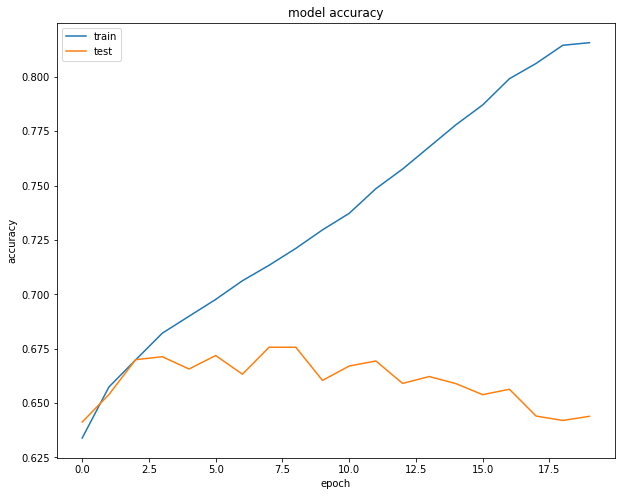

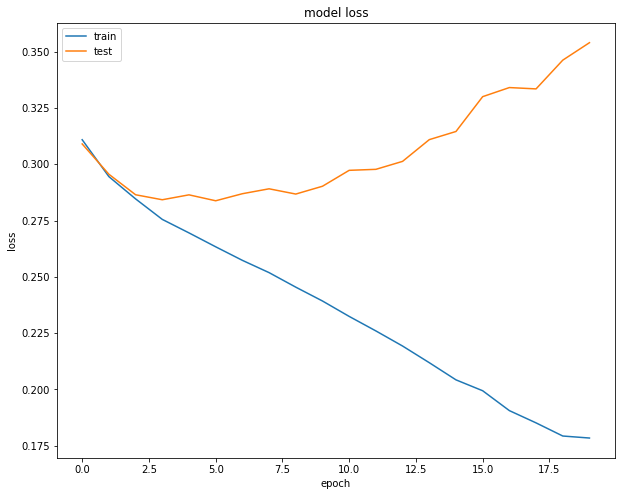

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()